## filter data on MTA_Hourly_Ridership
- give an overall description on the data, df_2024 has 27M rows, data running is a little bit time consuming
- since transfers ⊆ ridership, we dump 'transfers'

In [ ]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
import numpy as np

In [ ]:
# read the .csv file
df = dd.read_csv('MTA_Subway_Hourly_Ridership__2020-2024_20250415.csv', dtype={'station_complex_id': 'object'})

print(df.columns)
print(df.head())

Index(['transit_timestamp', 'transit_mode', 'station_complex_id',
       'station_complex', 'borough', 'payment_method', 'fare_class_category',
       'ridership', 'transfers', 'latitude', 'longitude', 'Georeference'],
      dtype='object')
        transit_timestamp transit_mode station_complex_id    station_complex  \
0  11/16/2024 12:00:00 PM       subway                627  Franklin Av (C,S)   
1  10/02/2024 06:00:00 AM       subway                 71           8 Av (N)   
2  11/16/2024 01:00:00 PM       subway                245          18 Av (F)   
3  11/16/2024 01:00:00 PM       subway                262        67 Av (M,R)   
4  10/02/2024 07:00:00 AM       subway                251       Avenue U (F)   

    borough payment_method fare_class_category  ridership  transfers  \
0  Brooklyn           omny    OMNY - Full Fare        247          8   
1  Brooklyn           omny        OMNY - Other          1          0   
2  Brooklyn           omny     OMNY - Students         20     

#### 1. Time Analysis: 'transit_timestamp'
- year = 2024 -> 27023932 rows
- we can easily tell the peak hours and weekly pattern from the heatmap
- it gives us evidence that select '6:00AM - 10:00AM' to analyze the single trips

In [ ]:
# filter year = 2024
df['transit_timestamp'] = dd.to_datetime(
    df['transit_timestamp'],
    format="%m/%d/%Y %I:%M:%S %p",
    errors='coerce'
)

df_2024 = df[df['transit_timestamp'].dt.year == 2024]
print(df_2024.head())

    transit_timestamp transit_mode station_complex_id    station_complex  \
0 2024-11-16 12:00:00       subway                627  Franklin Av (C,S)   
1 2024-10-02 06:00:00       subway                 71           8 Av (N)   
2 2024-11-16 13:00:00       subway                245          18 Av (F)   
3 2024-11-16 13:00:00       subway                262        67 Av (M,R)   
4 2024-10-02 07:00:00       subway                251       Avenue U (F)   

    borough payment_method fare_class_category  ridership  transfers  \
0  Brooklyn           omny    OMNY - Full Fare        247          8   
1  Brooklyn           omny        OMNY - Other          1          0   
2  Brooklyn           omny     OMNY - Students         20          0   
3    Queens           omny    OMNY - Full Fare         92          0   
4  Brooklyn           omny        OMNY - Other          1          0   

    latitude  longitude                  Georeference  
0  40.681380 -73.956850    POINT (-73.95685 40.68138) 

In [ ]:
df_2024.shape[0].compute()

27023932

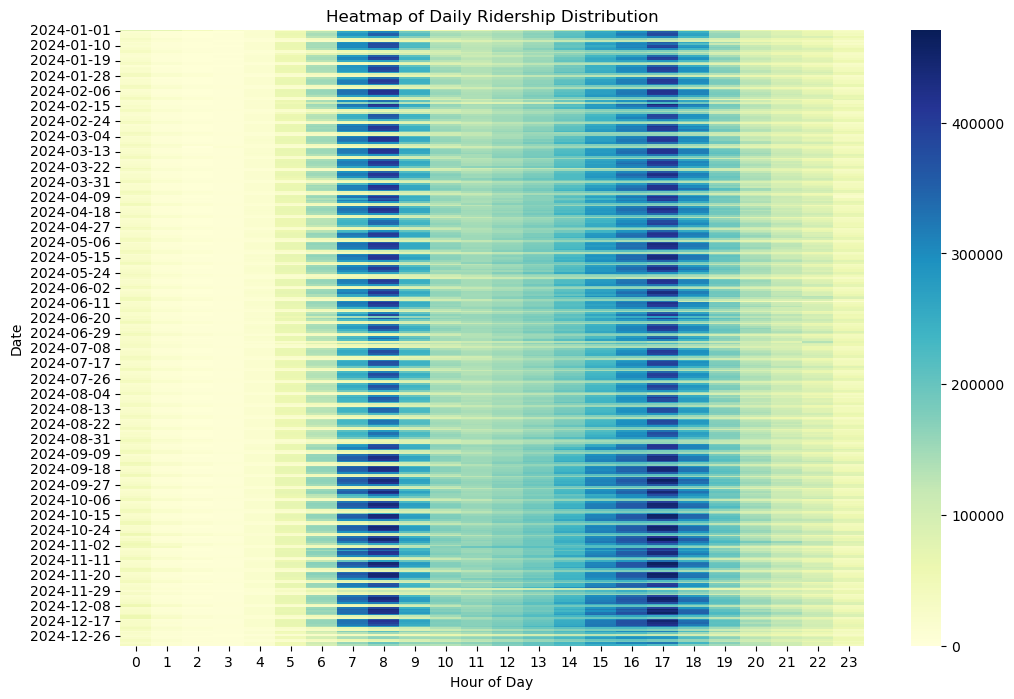

In [ ]:
# draw a heatmap to decide which period to choose
df_2024['hour'] = df_2024['transit_timestamp'].dt.hour
df_2024['date'] = df_2024['transit_timestamp'].dt.date

# aggregation with 'ridership'
hourly_ridership = df_2024.groupby(['date', 'hour'])['ridership'].sum().compute()
hourly_ridership = hourly_ridership.unstack(fill_value=0)

# rank the date
hourly_ridership = hourly_ridership.sort_index(ascending=True)

# plt
plt.figure(figsize=(12, 8))
sns.heatmap(hourly_ridership, cmap='YlGnBu', annot=False, cbar=True)

plt.title('Heatmap of Daily Ridership Distribution')
plt.xlabel('Hour of Day')
plt.ylabel('Date')

plt.show()

#### 2. Station: 'station_complex_id' and 'station_complex'

#### 3. Payment: 'payment_method' and 'fare_class_category'

In [ ]:
payment_unique = df_2024['payment_method'].unique().compute()
print(payment_unique)

0         omny
1    metrocard
Name: payment_method, dtype: object


In [ ]:
payment_ridership = df_2024.groupby('payment_method')['ridership'].sum().compute().sort_values(ascending=False)

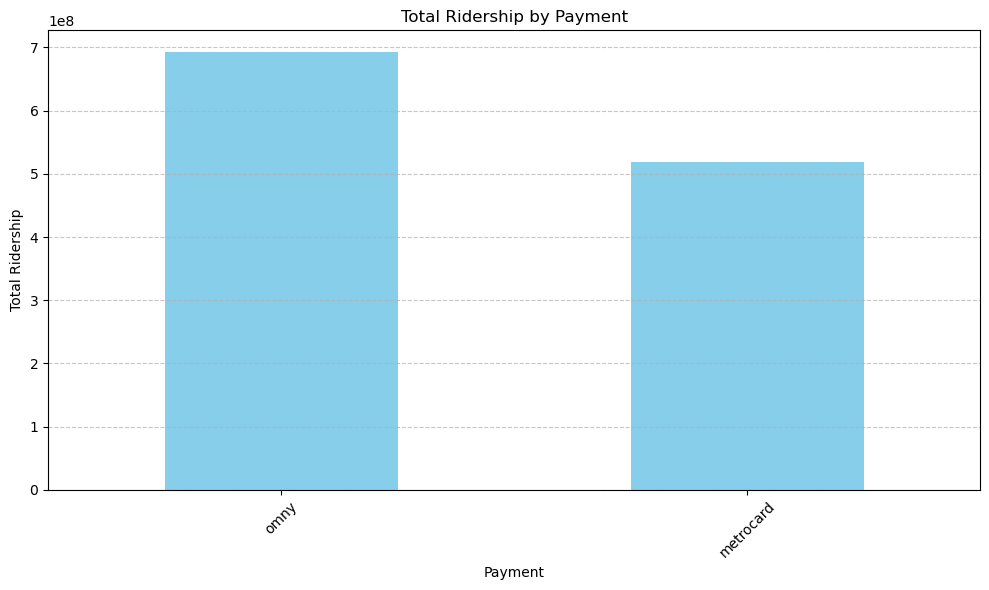

In [ ]:
# plt
plt.figure(figsize=(10, 6))
payment_ridership.plot(kind='bar', color='skyblue')

plt.title('Total Ridership by Payment')
plt.xlabel('Payment')
plt.ylabel('Total Ridership')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
fare_class_unique = df_2024['fare_class_category'].unique().compute()
print(fare_class_unique)

0                     OMNY - Full Fare
1                         OMNY - Other
2                      OMNY - Students
3         Metrocard - Unlimited 30-Day
4     Metrocard - Seniors & Disability
5                    Metrocard - Other
6                Metrocard - Fair Fare
7                Metrocard - Full Fare
8          OMNY - Seniors & Disability
9          Metrocard - Unlimited 7-Day
10                    OMNY - Fair Fare
11                Metrocard - Students
Name: fare_class_category, dtype: object


In [ ]:
# Step 1: 聚合每种刷卡方式的总人次
fare_class_ridership = (
    df_2024.groupby('fare_class_category')['ridership']
    .sum()
    .compute()
    .reset_index()
)

# 删除缺失值（避免 NaN）
fare_class_ridership = fare_class_ridership.dropna(subset=['fare_class_category'])

# 查看实际有哪些刷卡类别
print(fare_class_ridership['fare_class_category'].unique())



['Metrocard' 'OMNY']


In [ ]:
print(fare_class_ridership['fare_class_category'].unique())


[NaN]
Categories (12, object): ['OMNY - Full Fare' < 'OMNY - Fair Fare' < 'OMNY - Students' < 'OMNY - Seniors & Disability' ... 'Metrocard - Fair Fare' < 'Metrocard - Students' < 'Metrocard - Seniors & Disability' < 'Metrocard - Other']


#### 4. Geospatial Analysis: 'borough', 'latitude', 'longitude' and 'Georeference'

In [ ]:
borough_unique = df_2024['borough'].unique().compute()
print(borough_unique)

0         Brooklyn
1           Queens
2            Bronx
3        Manhattan
4    Staten Island
Name: borough, dtype: object


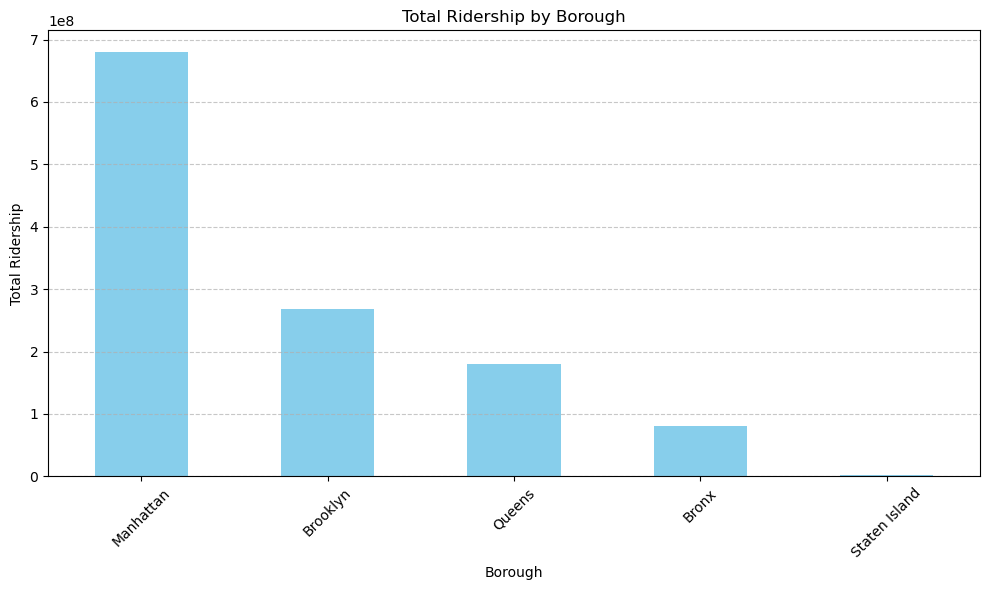

In [ ]:
borough_ridership = df_2024.groupby('borough')['ridership'].sum().compute().sort_values(ascending=False)

# plt
plt.figure(figsize=(10, 6))
borough_ridership.plot(kind='bar', color='skyblue')

plt.title('Total Ridership by Borough')
plt.xlabel('Borough')
plt.ylabel('Total Ridership')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()